# all_models_new_data.ipynb

This takes the csv created from `merge_sale_dates.ipynb` and runs it through different models. We also will do the data balancing here to try and get it to guess days on sale.

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")

In [67]:
games_df = pd.read_csv('all_data_sale_start_only.csv')
games_df['Date'] = pd.to_datetime(games_df['Date'])
games_df['releasedate'] = pd.to_datetime(games_df['releasedate'])

# Drop discount and final price from X since these allude to there being a sale
y = games_df['onSale']
X = games_df.drop('Discount',axis=1)
X = X.drop('Finalprice',axis=1)
X = X.drop('onSale',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
train_data = pd.concat([X_train, y_train], axis=1)

majority_class = train_data[train_data['onSale'] == 0]
minority_class = train_data[train_data['onSale'] == 1]

minority_class_oversampled = resample(minority_class,replace=True,n_samples=len(majority_class),random_state=42)

oversampled_data = pd.concat([majority_class, minority_class_oversampled])

X_train_resampled = oversampled_data.drop('onSale', axis=1)
y_train_resampled = oversampled_data['onSale']

In [69]:
X_train_resampled['DayOfWeek'] = X_train_resampled['Date'].dt.dayofweek
X_train_resampled['Month'] = X_train_resampled['Date'].dt.month
X_train_resampled['Year'] = X_train_resampled['Date'].dt.year
X_test['DayOfWeek'] = X_test['Date'].dt.dayofweek
X_test['Month'] = X_test['Date'].dt.month
X_test['Year'] = X_test['Date'].dt.year

X_train_resampled['ReleaseDayOfWeek'] = X_train_resampled['releasedate'].dt.dayofweek
X_train_resampled['ReleaseMonth'] = X_train_resampled['releasedate'].dt.month
X_train_resampled['ReleaseYear'] = X_train_resampled['releasedate'].dt.year
X_test['ReleaseDayOfWeek'] = X_test['releasedate'].dt.dayofweek
X_test['ReleaseMonth'] = X_test['releasedate'].dt.month
X_test['ReleaseYear'] = X_test['releasedate'].dt.year

#drop the old date
X_train_resampled = X_train_resampled.drop(['Date'], axis=1).drop(['releasedate'],axis=1)
X_test = X_test.drop(['Date'], axis=1).drop(['releasedate'],axis=1)

In [83]:
def fitAndPrint(X_train_resampled, X_test, y_train_resampled, y_test, depth):
    model = DecisionTreeClassifier(max_depth=depth)

    # Train the model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)

    plt.figure(figsize=(12, 8))
    plot_tree(model, filled=True, feature_names=X_train_resampled.columns.to_list(), rounded=True)
    plt.show()

    # Make predictions on the testing set
    test_prediction = model.predict(X_test)
    train_prediction = model.predict(X_train_resampled)

    cm = confusion_matrix(y_test, test_prediction)

    # Display the confusion matrix as a heatmap using matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar(cax)

    # Set labels for the confusion matrix
    classes = ['Not on Sale', 'On Sale']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Display the values in each cell
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=12)

    # Set labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    plt.show()

    report = classification_report(y_test, test_prediction)
    print(report)

    # Evaluate the accuracy
    test_accuracy = accuracy_score(y_test, test_prediction)
    train_accuracy = accuracy_score(y_train_resampled, train_prediction)

    y_test_array = np.array(y_test)
    print(y_test_array)
    print(test_prediction)
    num_correct = 0

    correct_positives = np.sum((y_test == 1) & (test_prediction == 1))
    total_positives = np.sum(y_test == 1)
    accuracy_positives = correct_positives / total_positives if total_positives > 0 else 0

    incorrect_positives = np.sum((y_test == 0) & (test_prediction == 1))
    total_positives_guessed = np.sum(test_prediction == 1)
    accuracy_positives_guessed = (total_positives_guessed - incorrect_positives) / total_positives_guessed if total_positives_guessed > 0 else 0

    print(correct_positives,"guessed correctly 'onSale' = 1 out of", total_positives, "total 'onSale' = 1 examples")
    print("Percentage of correct sale days found:", accuracy_positives)
    print("Guessed", incorrect_positives, "incorrect positives out of", total_positives_guessed, "total positives guessed")
    print("Percentage of positive sales that were actually sales:", accuracy_positives_guessed)
    print(f'Testing Accuracy: {test_accuracy}')
    print(f'Training Accuracy: {train_accuracy}')

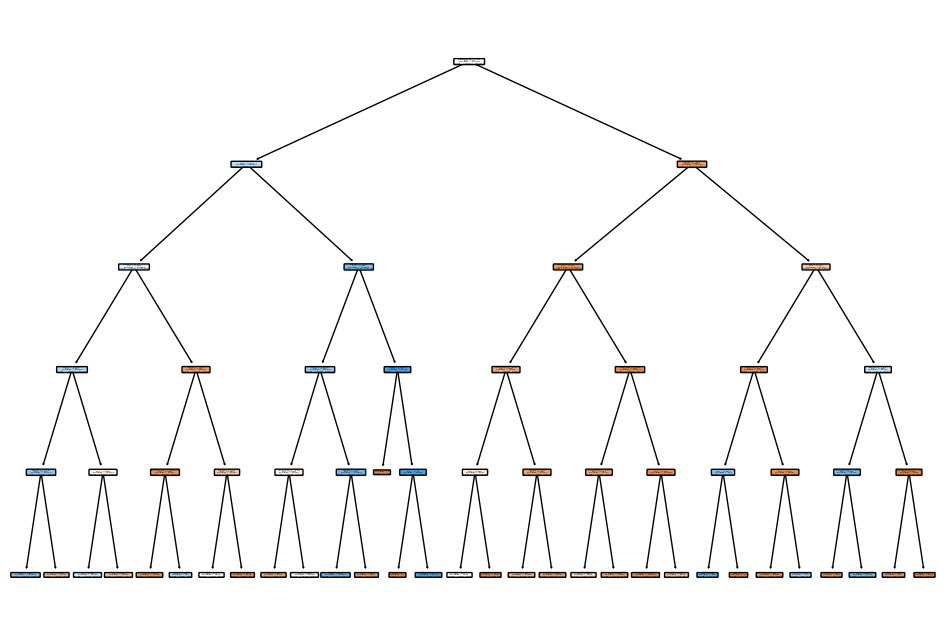

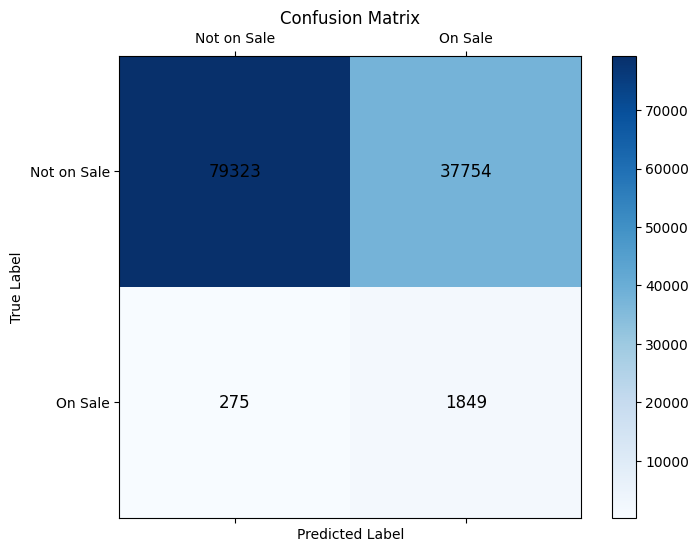

              precision    recall  f1-score   support

           0       1.00      0.68      0.81    117077
           1       0.05      0.87      0.09      2124

    accuracy                           0.68    119201
   macro avg       0.52      0.77      0.45    119201
weighted avg       0.98      0.68      0.79    119201

[0 0 0 ... 0 0 1]
[0 1 0 ... 1 1 1]
1849 guessed correctly 'onSale' = 1 out of 2124 total 'onSale' = 1 examples
Accuracy of sale predictions: 0.870527306967985
Testing Accuracy: 0.6809674415483091
Training Accuracy: 0.7693259214315624


In [84]:
# names = [
#     "Nearest Neighbors",
#     "Decision Tree",
#     "Random Forest",
#     "Neural Net",
#     "AdaBoost",
#     "Naive Bayes",
# ]

# classifiers = [
#     KNeighborsClassifier(3),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1, max_iter=1000),
#     AdaBoostClassifier(),
#     GaussianNB(),
# ]

# for i in range(len(classifiers)):
#     cn = names[i]
#     clf = classifiers[i]
#     clf.fit(X_train_resampled, y_train_resampled)
#     y_predict = clf.predict(X_train_resampled)
#     train_acc = accuracy_score(y_train_resampled, y_predict)

#     y_predict = clf.predict(X_test)
#     test_acc = accuracy_score(y_test, y_predict)

#     print("Name:", cn)
#     print("Training:", train_acc)
#     print("Testing:", test_acc)
#     print("\n")

fitAndPrint(X_train_resampled, X_test, y_train_resampled, y_test, 5)
